In [8]:
# Picture to Picture GAN augmenting image richness (also entropy). 
# Used to augment synthetic images with near realistic short range aspects
# Author Marc Fiammante Oktal-SE
# adapted from https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/
#
import numpy as np
import cv2
import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img,save_img
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from copy import deepcopy

import os
cwd = os.getcwd()

# Convolution kernel and strides for the layers of the discrimator and encoder. Also used backwards for the decoder
# Rather shallow model as we are looking to act on short range features, the global aspect of the source image being
# preserved
convstride=np.array([[[2,2],[1,1]],[[3,3],[2,2]],[[4,4],[3,3]],[[4,4],[4,4]],[[4,4],[4,4]]])

# define the discriminator model
def define_discriminator(image_shape):
        convstrided=convstride.copy()
        print(convstrided.shape)
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # source image input
        in_src_image = Input(shape=image_shape)
        # target image input
        in_target_image = Input(shape=image_shape)
        # concatenate images channel-wise
        merged = Concatenate()([in_src_image, in_target_image])
        # C64
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(24, conv, strides=stride, padding='same', kernel_initializer=init)(merged)
        d = LeakyReLU(alpha=0.2)(d)
        # C128
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(32, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # C256
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(64, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # second last output layer
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(160, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # patch output
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(1, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        patch_out = Activation('sigmoid')(d)
        # define model
        model = Model([in_src_image, in_target_image], patch_out)
        # compile model
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
        #model.summary()
        return model

# define an encoder block
def define_encoder_block(layer_in,name, n_filters,kernel=(3,3),strides=(2,2), batchnorm=True):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # add downsampling layer
        g = Conv2D(n_filters, kernel, strides=strides, padding='same', kernel_initializer=init,name=name)(layer_in)
        # conditionally add batch normalization
        if batchnorm:
            g = BatchNormalization()(g, training=True)
        # leaky relu activation
        g = LeakyReLU(alpha=0.2)(g)
        return g

# define a decoder block
def decoder_block(layer_in, skip_in,name, n_filters,kernel=(3,3),strides=(2,2), dropout=True):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # add upsampling layer
        g = Conv2DTranspose(n_filters, kernel, strides=strides, padding='same', kernel_initializer=init,name=name)(layer_in)
        # add batch normalization
        g = BatchNormalization()(g, training=True)
        # conditionally add dropout
        if dropout:
            g = Dropout(0.5)(g, training=True)
        # merge with skip connection
        g = Concatenate()([g, skip_in])
        # relu activation
        g = Activation('relu')(g)
        return g

# define the standalone generator model
def define_generator(image_shape):
        convstrideg=convstride.copy()
        print(convstrideg.shape)
        init = RandomNormal(stddev=0.02)
        # image input
        in_image = Input(shape=image_shape)
        # encoder model
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e1 = define_encoder_block(in_image,"encoder_block_1", 24, kernel=conv,strides=stride,batchnorm=False) # 64
        
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e2 = define_encoder_block(e1,"encoder_block_2", 32,kernel=conv,strides=stride) # 16
        
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e3 = define_encoder_block(e2,"encoder_block_3", 48,kernel=conv,strides=stride) # 16
        
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e4 = define_encoder_block(e3,"encoder_block_4", 56,kernel=conv,strides=stride) # 16
        # bottleneck, no batch norm and relu
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        b = Conv2D(64, conv,strides=stride, padding='same', kernel_initializer=init,name="bottleneck_conv2d")(e4)
        b = Activation('relu')(b)
        # decoder model
        convstrideg=convstride.copy()
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d4 = decoder_block(b, e4,"decoder_block_4", 64,kernel=conv,strides=stride, dropout=True)
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d5 = decoder_block(d4, e3,"decoder_block_3",56,kernel=conv,strides=stride, dropout=True)
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d6 = decoder_block(d5, e2,"decoder_block_2", 48,kernel=conv,strides=stride, dropout=True)
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d7 = decoder_block(d6, e1,"decoder_block_1", 32,kernel=conv,strides=stride, dropout=True)
        # output
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        g = Conv2DTranspose(3, conv,strides=stride, padding='same',kernel_initializer=init)(d7)
        out_image = Activation('tanh')(g)
        
        # define model
        model = Model(in_image, out_image)
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
        #model.summary()
        return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
        # make weights in the discriminator not trainable
        for layer in d_model.layers:
            if not isinstance(layer, BatchNormalization):
                  layer.trainable = False
        # define the source image
        in_src = Input(shape=image_shape)
        # connect the source image to the generator input
        gen_out = g_model(in_src)
        # connect the source input and generator output to the discriminator input
        dis_out = d_model([in_src, gen_out])
        # src image as input, generated image and classification output
        model = Model(in_src, [dis_out, gen_out])
        # compile model
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
        return model

# load and prepare training images file names. consists of Pairs of low richness, real images.
def load_real_samples(filename):
        # load compressed arrays
        data = load(filename)
        # unpack arrays
        X1, X2 = data['arr_0'], data['arr_1']
        return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape1,patch_shape2):
        #print("generate_real_samples",patch_shape1,patch_shape2)
        # unpack dataset
        trainA, trainB = dataset
        # choose random instances
        ix = randint(0, trainA.shape[0], n_samples)
        X1=[]
        X2=[]
        # now read the input image files (difference from the code it is derived from that preloads all images)
        for i in ix:
            image = cv2.imread(trainA[i])
            src=image
            X1.append(src)
            image = cv2.imread(trainB[i])
            tgt=image
            X2.append(tgt)
        X1=np.array(X1)
        X1 = (X1 - 127.5) / 127.5
        X2=np.array(X2)
        X2 = (X2 - 127.5) / 127.5
        # generate 'real' class labels (1)
        y = ones((n_samples, patch_shape1, patch_shape2, 1))
        return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape1,patch_shape2):
    # generate fake instance
    X = g_model.predict_on_batch(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape1, patch_shape2, 1))
    return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset,patch_shape1,patch_shape2, n_samples=1):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples,patch_shape1,patch_shape2)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, patch_shape1,patch_shape2)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = 255*(X_realA + 1) / 2.0
    X_realB = 255*(X_realB + 1) / 2.0
    X_fakeB = 255*(X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        img=cv2.cvtColor(X_realA[i].astype(np.uint8), cv2.COLOR_BGR2RGB)
        pyplot.imshow(img)
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')       
        img=cv2.cvtColor(X_fakeB[i].astype(np.uint8), cv2.COLOR_BGR2RGB)
        pyplot.imshow(img)
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        img=cv2.cvtColor(X_realB[i].astype(np.uint8), cv2.COLOR_BGR2RGB)
        pyplot.imshow(img)
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'g_model.h5' 
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch1 = d_model.output_shape[1]
    n_patch2 = d_model.output_shape[2]
    print(d_model.output_shape)
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # limit steps to 5000 per run
    if n_steps>5000:
        n_steps=1
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch1,n_patch2)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch1,n_patch2)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance every 200 steps
        if (i+1) % 200 == 0:
              summarize_performance(i, g_model, dataset,n_patch1,n_patch2)
    g_model.save_weights ('C:/projets/oktal-se/g_model.h5')
    return(d_model, g_model)

# load image data
filename = 'entropy_256.npz'
dataset = load_real_samples(filename)
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
pixels = load_img(dataset[0][0])
# convert to numpy array
tgt = img_to_array(pixels)
print(tgt.shape)
image_shape = tgt.shape
# define the models
print(image_shape)
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
print(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)

#load initial weights
#print("d_model")
d_model.load_weights ('d_model.h5')
print("g_model")
g_model.load_weights ('g_model.h5')
print("gan_model")
gan_model.load_weights ('gan_model.h5')

# train model
(d_model, g_model)=train(d_model, g_model, gan_model, dataset,n_epochs=100, n_batch=1)

# save models

print("gan_model")
gan_model.save_weights ('gan_model.h5')
d_model.save_weights('d_model.h5')
g_model.save_weights('g_model.h5')


Loaded (130,) (130,)
(672, 960, 3)
(672, 960, 3)
(5, 2, 2)
(5, 2, 2)
(672, 960, 3)
g_model
gan_model
(None, 7, 10, 1)
>1, d1[0.047] d2[0.431] g[5.693]
gan_model


In [9]:
# try on a test image
import cv2
from tensorflow import keras
from keras.preprocessing.image import load_img,save_img
from keras.preprocessing.image import img_to_array
import numpy as np

X=[]
src = cv2.imread('test/terrain_avant.png')
X.append(src)
X = (np.array(X) - 127.5) / 127.5
x1 = g_model.predict(X)
X1=np.array(x1)
x1 = X1*127.5+127.5
img=x1[0]
cv2.imwrite('test/terrain_gan.png',img.astype(int))

True

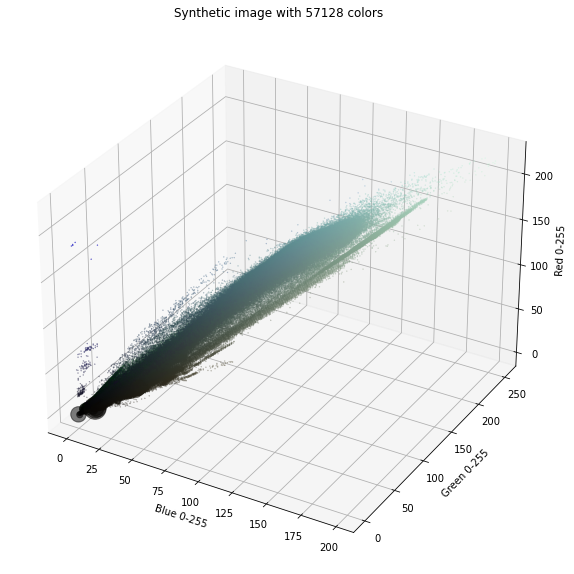

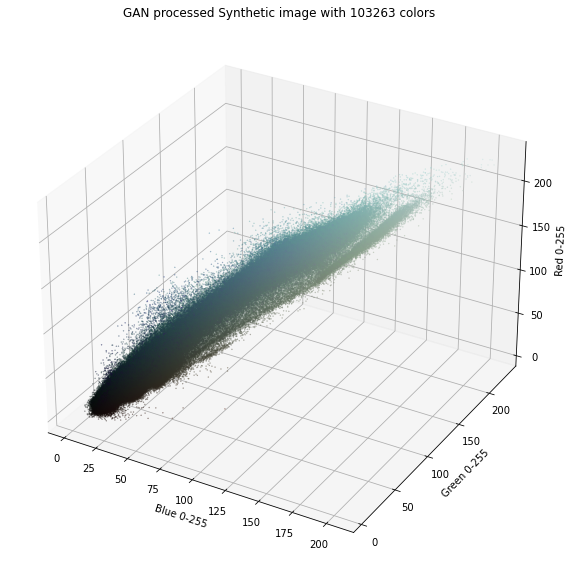

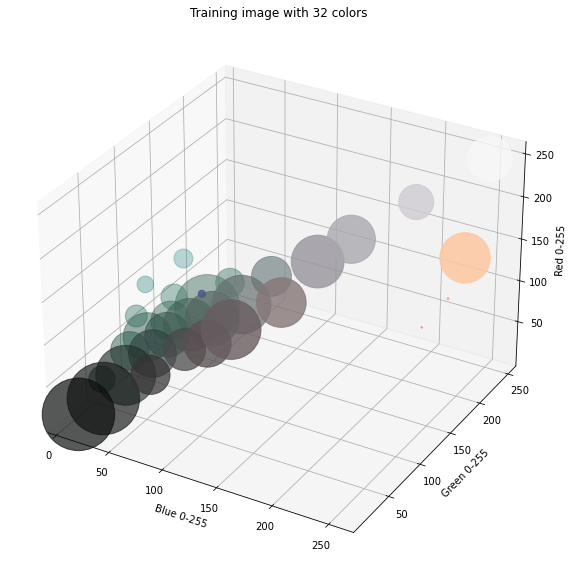

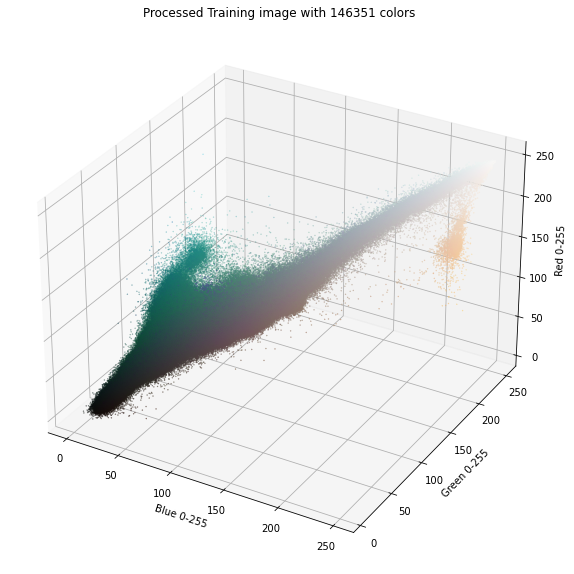

In [10]:
# create source and transformed images scatter plot to see augmentation
import numpy as np
import cv2 as cv
from scipy import stats
from matplotlib import pyplot as plt
def plot3Dcolorscatter(imgfile,title):
    plt.rcParams['figure.figsize'] = [14, 10]
    img = cv.imread(imgfile)
    unique, counts = np.unique(img.reshape(-1, img.shape[-1]), axis=0, return_counts=True)
    ax = plt.axes(projection = '3d')
    x = [];y = [];z = [];c = [];s = []
    for i,col in enumerate(unique):
        x.append(col[0]);y.append(col[1]);z.append(col[2])
        c.append((col[0] / 255, col[1] / 255, col[2] / 255))
        s.append(counts[i]/10)

    ax.scatter(x,y,z, c = c,s=s)
    ax.set_xlabel('Blue 0-255')
    ax.set_ylabel('Green 0-255')
    ax.set_zlabel('Red 0-255')
    plt.title(title+str(len(counts))+' colors')
    plt.show()
plot3Dcolorscatter('test/terrain_avant.png','Synthetic image with ')
plot3Dcolorscatter('test/terrain_gan.png','GAN processed Synthetic image with ')
plot3Dcolorscatter('test/img3_0_255.png','Training image with ' )
plot3Dcolorscatter('test/img3_0_255_gan.png','Processed Training image with ' )

before
number of colors 57128
after
number of colors 109282


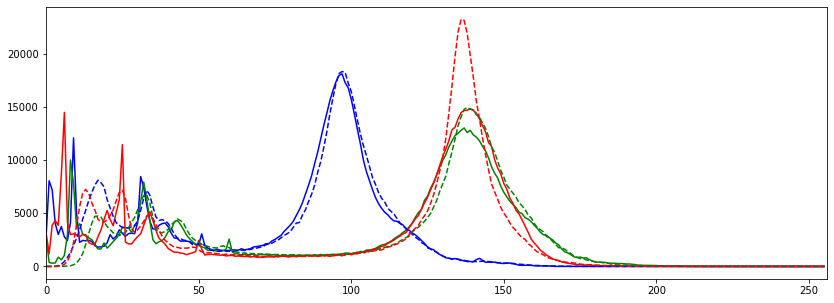

In [7]:
# create on training pair histogram plot to see augmentation
import numpy as np
import cv2 as cv
from scipy import stats
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [14, 5]
img = cv.imread('test/terrain_avant.png')
color = ('b','g','r')
print("before")
unique, counts = np.unique(img.reshape(-1, img.shape[-1]), axis=0, return_counts=True)
print("number of colors",len(counts))
for i,col in enumerate(color):
    histr = cv.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])

img1 = cv2.imread('test/terrain_gan.png')
print("after")
unique, counts = np.unique(img1.reshape(-1, img1.shape[-1]), axis=0, return_counts=True)
print("number of colors",len(counts))
for i,col in enumerate(color):
    histr = cv2.calcHist([img1],[i],None,[256],[0,256]) 
    line=plt.plot(histr,color = col)
    plt.setp(line, linestyle='--') 
    plt.xlim([0,256])

plt.show()